In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./RNN_scripts")
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from RNN_scripts import dms, ranktwo, clustering
from RNN_scripts.modules import LowRankRNN, train
import seaborn as sns
import pickle

import MARBLE
from MARBLE import utils, geometry, plotting, postprocessing, compare_attractors
from example_utils import generate_trajectories, plot_experiment

In [2]:
matplotlib.rcParams['figure.figsize'] = (6, 5)
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.titlesize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

# Load trained model

In [17]:
hidden_size = 500#4096
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = dms.generate_dms_data(1000)
net =  LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load(f'./RNN_scripts/dms_rank2_{hidden_size}.pt', map_location='cpu'))
net.svd_reparametrization()

In [18]:
loss_orig, acc_orig = dms.test_dms(net, x_val, y_val, mask_val)
print(acc_orig)
print(loss_orig)

1.0
0.005372448358684778


# Visualising two network populations

In [5]:
n_pops = 2
z, _ = clustering.gmm_fit(net, n_pops, algo='bayes', random_state=2020)  # z will contain labels for the 2 populations

pop 0: slope=-0.01, intercept=-0.04
pop 1: slope=-0.03, intercept=0.06
pop 0: slope=-0.01, intercept=0.02
pop 1: slope=-0.02, intercept=-0.20


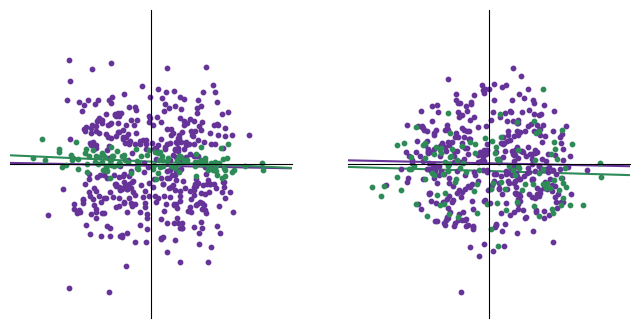

In [6]:
# Visualizing those 2 populations
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy() 
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
colors = ['rebeccapurple', 'seagreen']
fs = 12
clustering.pop_scatter_linreg(n, wi1, z, n_pops, colors=colors, ax=ax[0])
clustering.pop_scatter_linreg(n, wi2, z, n_pops, colors=colors, ax=ax[1])

# Design input

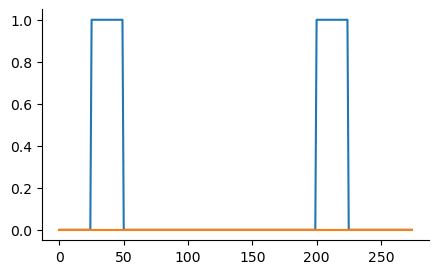

In [32]:
n_gains=20
stim1_begin, stim1_end, stim2_begin, stim2_end, decision = 25, 50, 200, 225, 275
epochs = [0, stim1_begin, stim1_end, stim2_begin, stim2_end, decision]
gain = np.linspace(1,0,n_gains)
    
input = torch.zeros(n_gains, decision, 2)
for i, g in enumerate(gain):
    input[i, stim1_begin:stim1_end, 0] = g
    input[i, stim2_begin:stim2_end, 0] = g
    
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.plot(input[0])
plt.savefig('./outputs/stim.svg')

# Plot phase portraits of the original system for various parameters

In [33]:
n_traj=50

traj = generate_trajectories(net, input, epochs, n_traj)

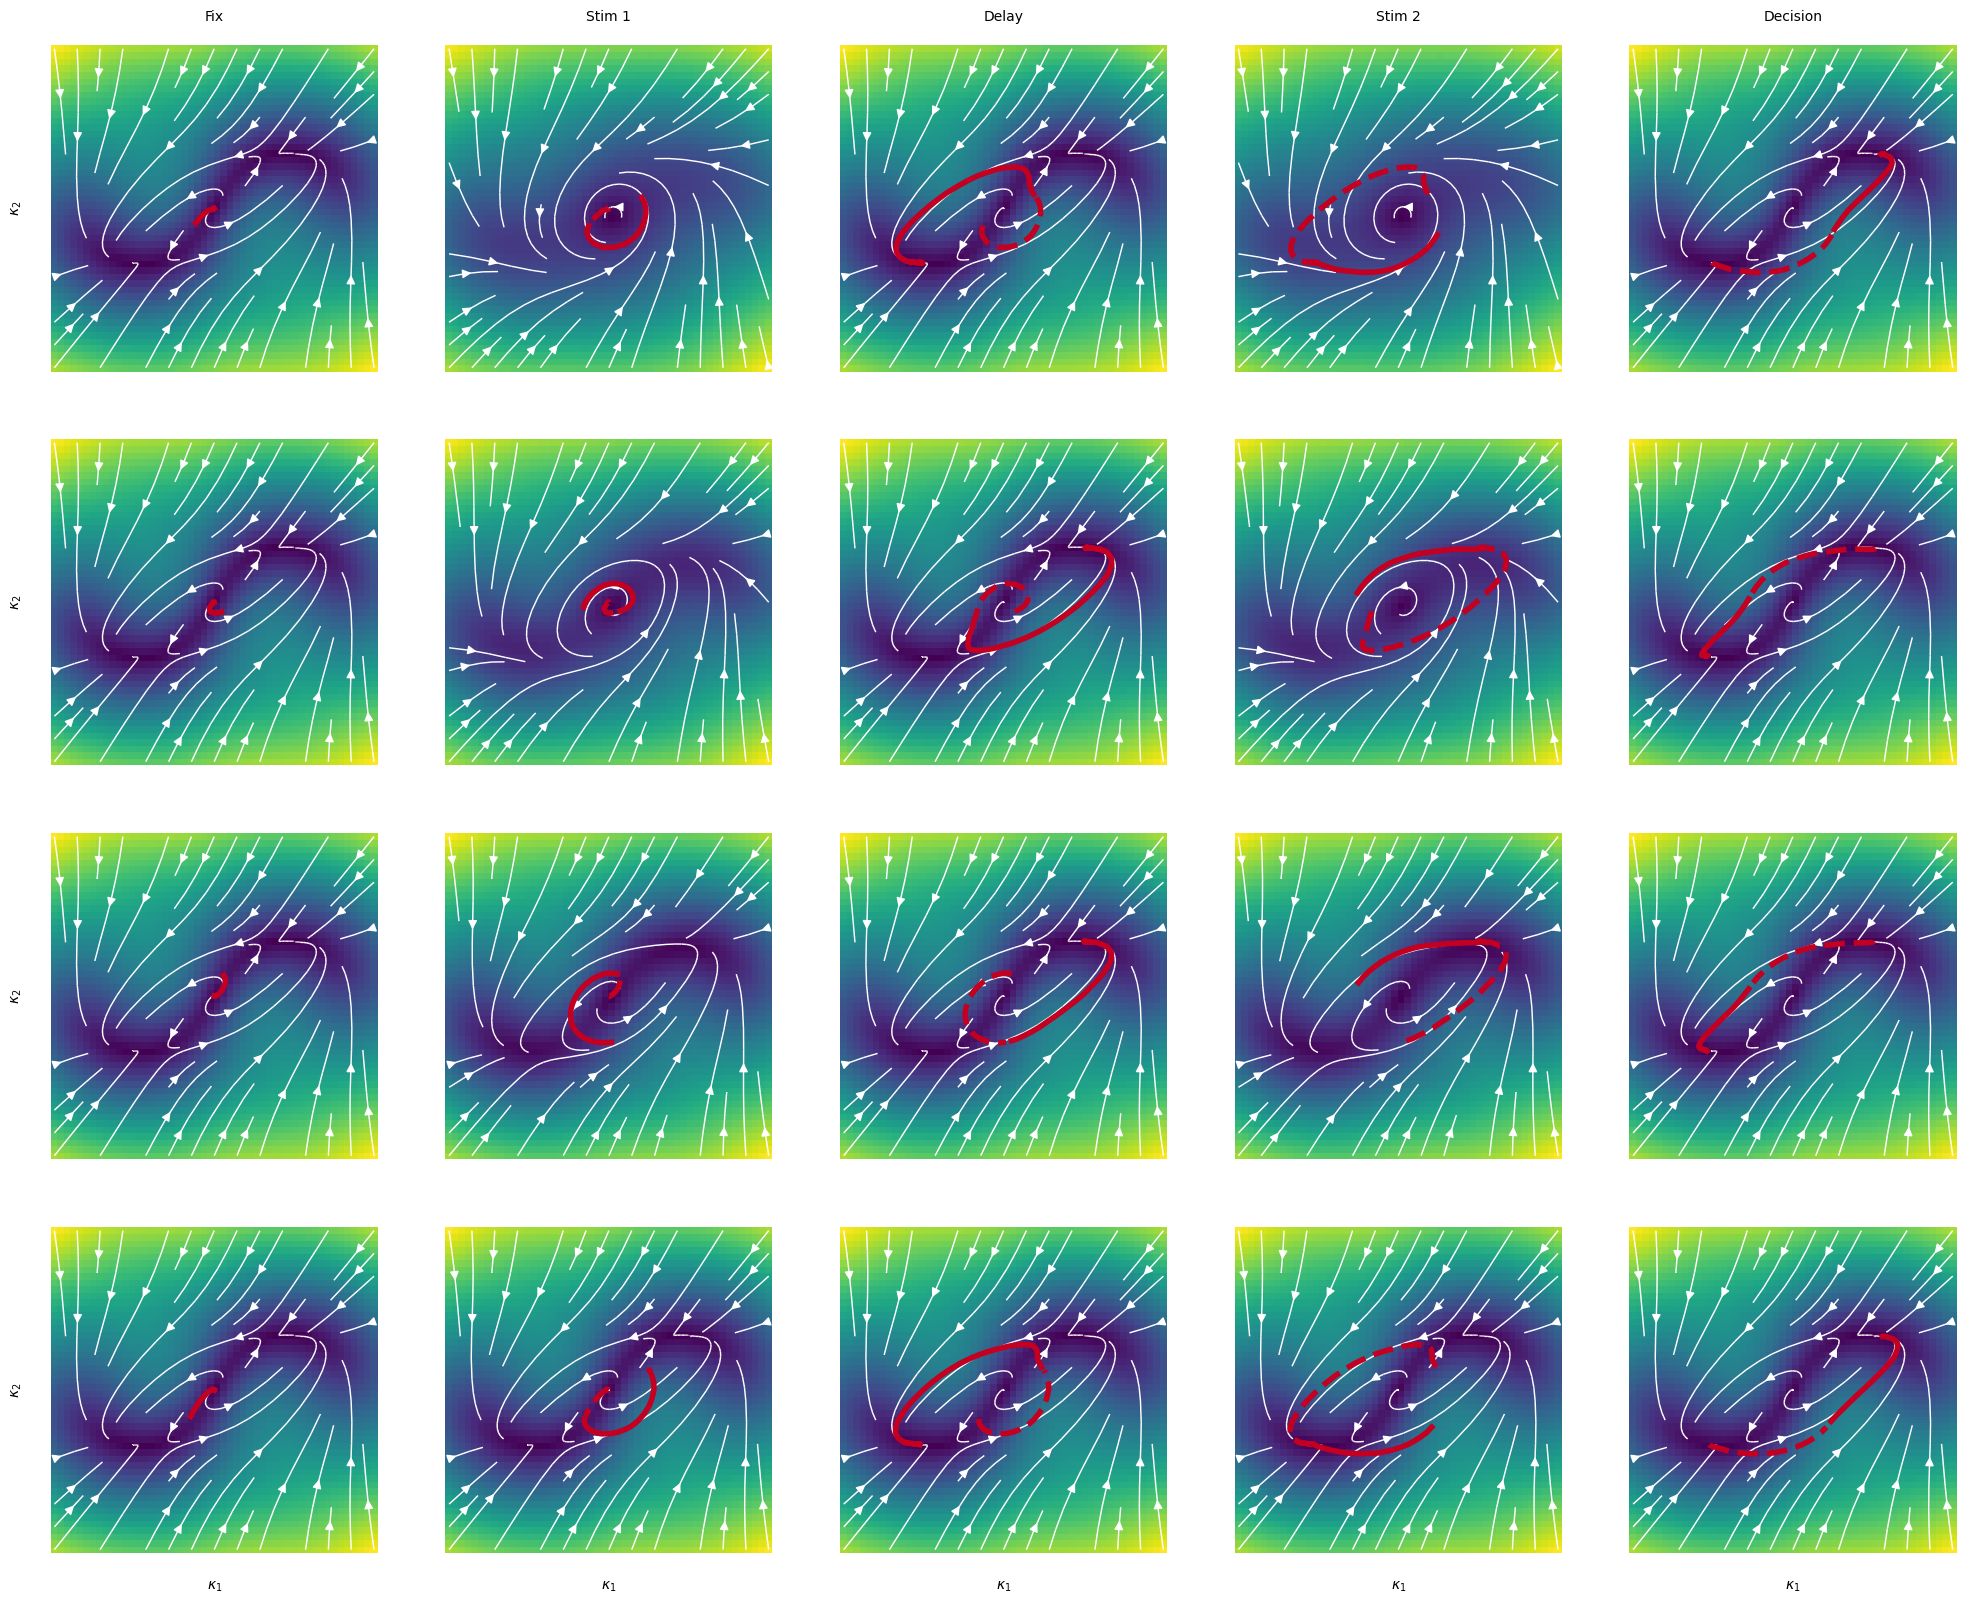

In [34]:
plot_experiment(net, input, traj, epochs)

#plt.savefig('./outputs/fields_all_conditions.svg')

# Create new network by fitting Gaussian mixture to the connectivity space

In [40]:
net_sampled = clustering.to_support_net(net, z, scaling=True)

Check that the resampled networks still give the same validation losses

In [41]:
accs2 = []
for _ in range(10):
    net_sampled.resample_basis()
    loss, acc = dms.test_dms(net_sampled, x_val, y_val, mask_val)
    accs2.append(acc)

Train net network for a few epochs

In [37]:
train(net_sampled, x_train, y_train, mask_train, 20, lr=1e-6, resample=True, keep_best=True, clip_gradient=1)

Training...
initial loss: 1.152
epoch 0:  loss=1.176  (took 6.06 s)
epoch 1:  loss=1.130  (took 5.90 s) *
epoch 2:  loss=1.135  (took 5.91 s)
epoch 3:  loss=1.117  (took 7.10 s) *
epoch 4:  loss=1.134  (took 5.64 s)
epoch 5:  loss=1.132  (took 5.87 s)
epoch 6:  loss=1.108  (took 5.88 s) *
epoch 7:  loss=1.125  (took 5.91 s)
epoch 8:  loss=1.147  (took 5.82 s)
epoch 9:  loss=1.125  (took 5.82 s)
epoch 10:  loss=1.134  (took 6.27 s)
epoch 11:  loss=1.172  (took 5.98 s)
epoch 12:  loss=1.168  (took 5.91 s)
epoch 13:  loss=1.162  (took 6.31 s)
epoch 14:  loss=1.114  (took 6.08 s)
epoch 15:  loss=1.099  (took 5.77 s) *


KeyboardInterrupt: 

# Plot phase portraits of the resampled system for various parameters

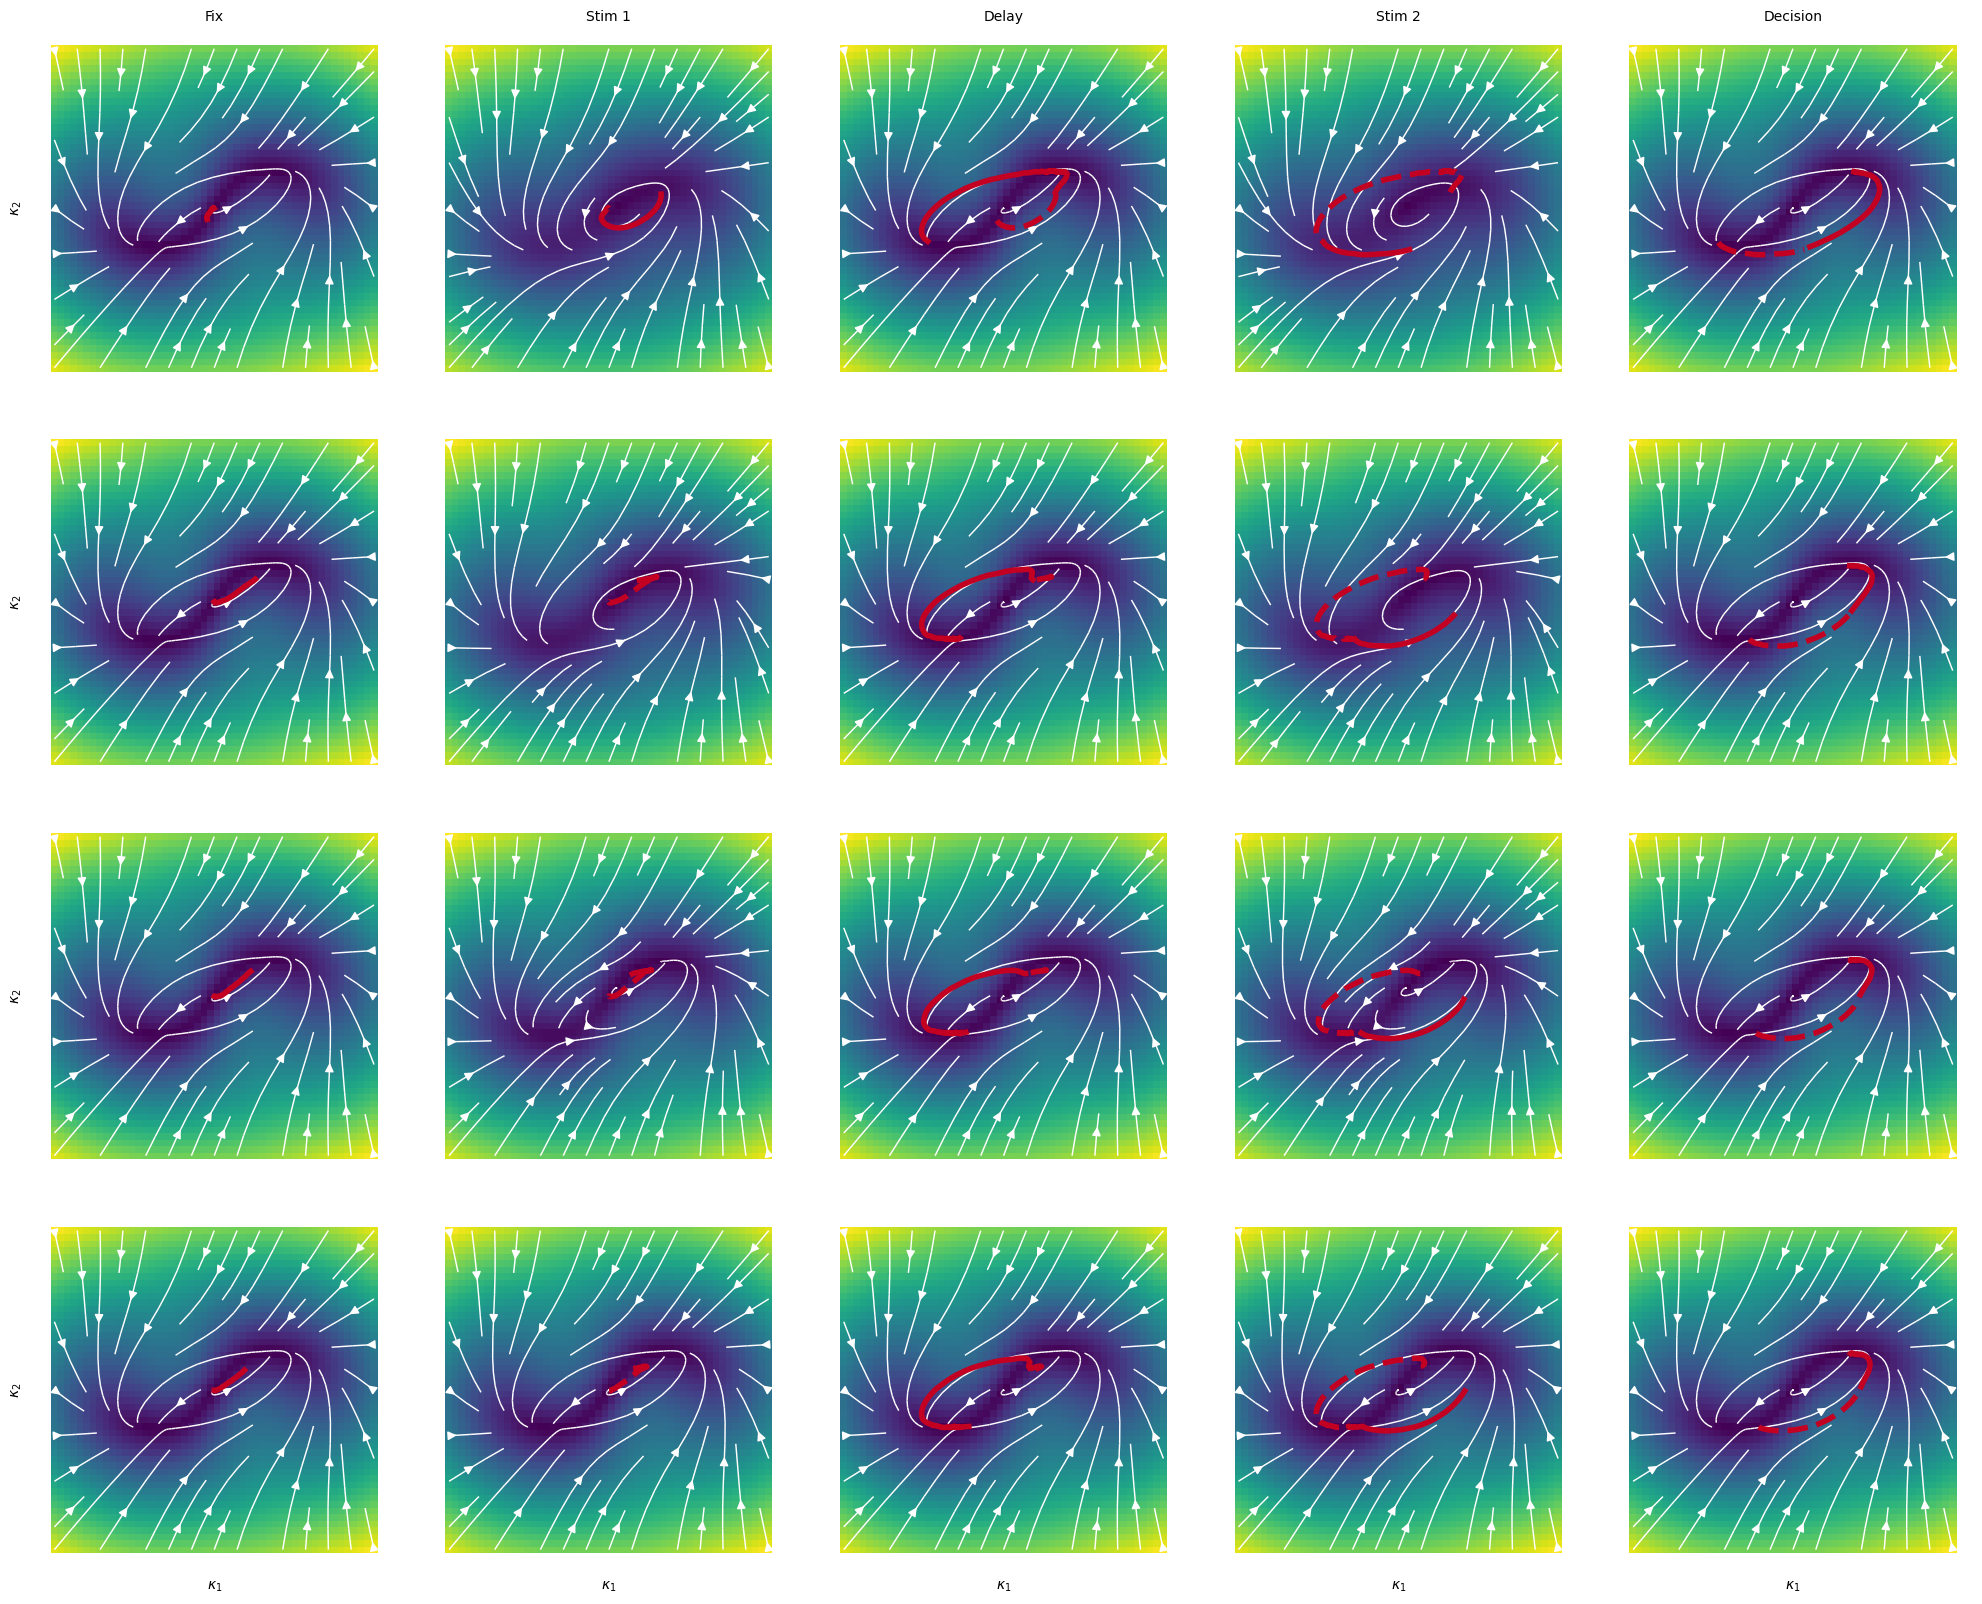

In [42]:
n_traj=50

traj_sampled = generate_trajectories(net_sampled, input, epochs, n_traj)
plot_experiment(net_sampled, input, traj_sampled, epochs)

In [ ]:
pickle.dump(traj, open('./outputs/RNN_data.pkl','wb'))

# Concatenate data and create dataset

In [ ]:
pos, vel = aggregate_data(traj, epochs)
data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=15, stop_crit=0.02)

In [ ]:
titles = [r'$gain$ = {:0.2f}, {}'.format(g, s) for s in ['stim', 'unstim'] for g in gain ]

plotting.fields(data, col=4, alpha=0.2, width=0.01, scale=200, titles=titles)
plt.show()

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

par = {'epochs': 100, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 3,
       'inner_product_features': True,
      }

model = MARBLE.net(data, **par)
model.run_training(data)

In [ ]:
data = model.evaluate(data)
n_clusters=20
data = postprocessing(data, n_clusters=n_clusters)

emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')
labels = [g for i in range(2) for g in gain ]
plotting.embedding(emb_MDS, labels, s=30, alpha=1)

In [ ]:
plt.imshow(data.dist)

In [ ]:
titles = [r'$gain$ = {:0.2f}, {}'.format(g, s) for s in ['stim', 'unstim'] for g in gain ]
plotting.embedding(data.emb_2d, data.y.numpy(), titles=titles)